In [54]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prerequisite Python Modules
First, some software needs to be loaded into the Python environment.

In [55]:
import tensorflow as tf
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers

from tensorflow.keras.models import Sequential  # Model type to be used
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Dropout, Activation
from tensorflow.keras.utils import to_categorical, plot_model

print(tf.__version__) # find the version number (should be 2.x+)

# 그래피카드 유무 확인 및 메모리 확장 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  print('사용가능한 GPU 갯수: ',len(gpus), '\n')
      
  try:
    # 프로그램이 실행되어 더 많은 GPU 메모리가 필요하면, 텐서플로 프로세스에 할당된 GPU 메모리 
    # 영역을 확장할 수있도록 허용
    tf.config.experimental.set_memory_growth(gpus[0], True)

  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)

# 설치된 GPU 상세내용 확인
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2.6.0
사용가능한 GPU 갯수:  1 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12446531112624064555
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14512029696
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16061810708094050013
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## Dataset

[Fashion MNIST Github Repo](https://github.com/zalandoresearch/fashion-mnist)

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

**Problem** - Given a grayscale image of fashion items predict the class from 10 different classes. Since each image contains only one item, it is a **multiclass-classification problem**.


Type of classification problems:
* Binary - Predict between two mutually exclusive outcomes. (spam or not spam; rain or no rain; positive sentiment or negative sentiment)
* Multiclass - Predict between n mutually exclusive outcomes. (above problem; sunny, rainy, windy;)
* Multilabel - Predict between n outcomes each of which can happen simultaneously (object detection in natural setting images; tags of a webpage/article)

In [56]:
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and testing sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Name of the classes
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

n_classes = len(class_names)
print(f'Number of classes: {n_classes}')

Number of classes: 10


In [57]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [58]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

**Note**:

* We have 60000 images in training set and 10000 in test set
* The dimension of the image is 28x28 (grayscale, all same dimensions)
* The labels are integer values from 0-9, with mapping in class_names


## Exploratory Data Analysis

Train labels:  {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


<BarContainer object of 10 artists>

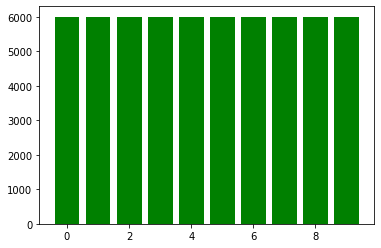

In [59]:
# Exploratory Data Analysis (EDA)

# count and plot the number of unique train labels
unique, counts = np.unique(y_train,return_counts=True)
y_train_dist = dict(zip(unique, counts))
print("Train labels: ", y_train_dist)
plt.bar(y_train_dist.keys(), y_train_dist.values(), color='g')

Test labels:  {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


<BarContainer object of 10 artists>

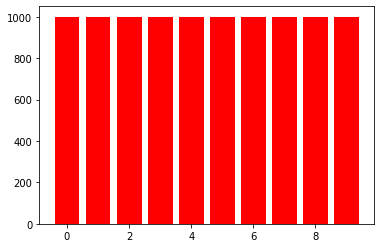

In [60]:
# count and plot the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
y_test_dist = dict(zip(unique, counts))
print("Test labels: ", y_test_dist)
plt.bar(y_test_dist.keys(), y_test_dist.values(), color='r')

The distribution is uniform in both with classes equally distributed between themselves as well as between train and test sets! :)

### Viewing 25 random train images 

In [61]:
# Plot 25 randomly selected images from train or test dataset

def random_view(images_dataset, labels_dataset, train=True):

  indexes = np.random.randint(0, images_dataset.shape[0], size=25)

  images = x_train[indexes]
  labels = y_train[indexes]


  # plot the 25 mnist digits
  plt.figure(figsize=(10,10))
  title = "Random Images from Train Dataset" if train else "Random Images from Test Dataset\n"
  plt.suptitle(title, fontsize=16, y=1.08)
  for i in range(len(indexes)):
      plt.subplot(5, 5, i + 1)
      image = images[i]
      plt.imshow(image, cmap='gray')
      plt.title('label: {}'.format(class_names[labels[i]]))
      plt.tight_layout()
      plt.axis('off')

  print("\n\n")


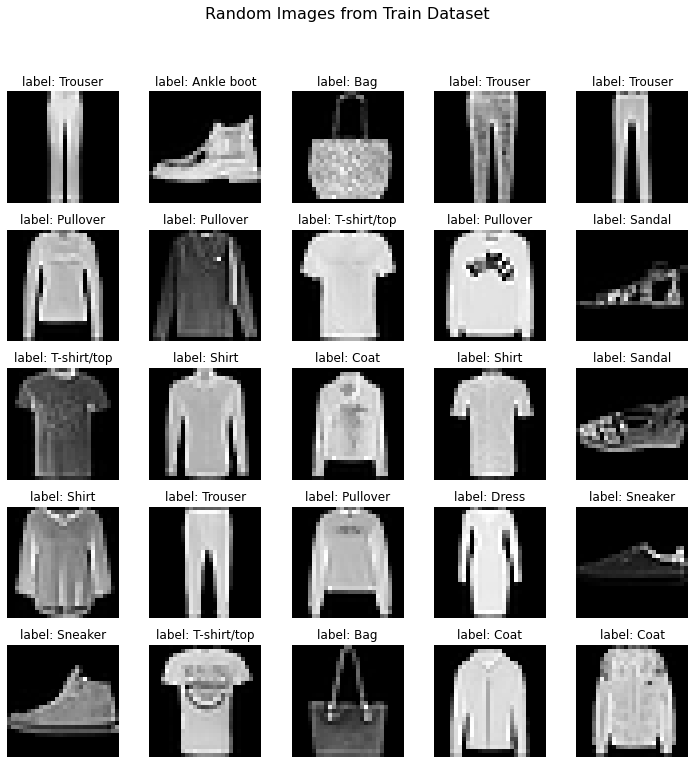

In [62]:
# Plot 25 randomly selected images from train dataset

random_view(x_train, y_train, True)

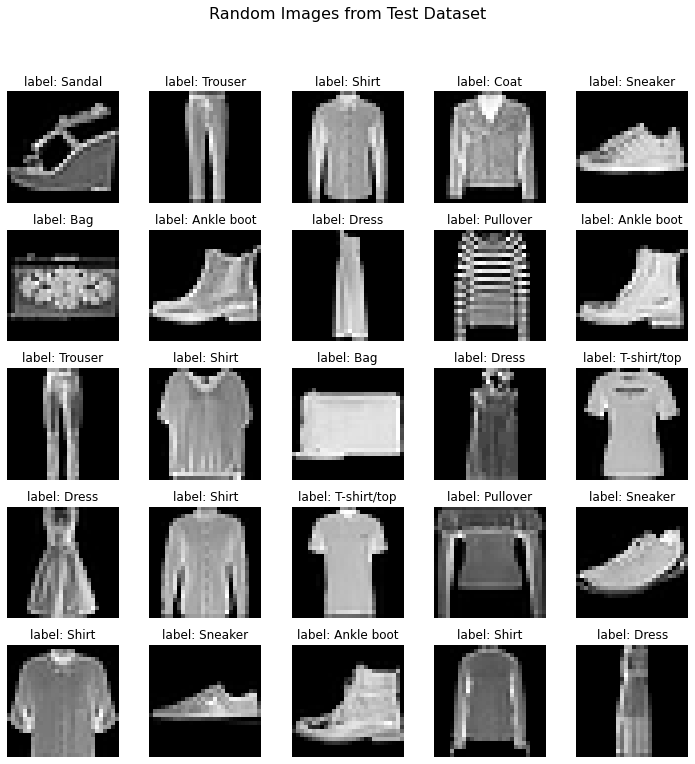

In [63]:
# Plot 25 randomly selected images from test dataset

random_view(x_test, y_test, False)

### View multiple random images from train/test dataset.

In [64]:
# Randomly sample n*n images from train or test dataset

import pandas as pd
import numpy as np

def plot_images(n, train=True):
  """
    Plot Randomly chosen n*n images from train or test dataset
      
      n: number of columns for plots (n by n subplots)
      Assume: train data = (x_train, y_train)
              test data = (x_test, y_test)
              
  """

  if train:
    indexes = np.random.randint(0, x_train.shape[0], size=n*n)
    images = x_train[indexes]
    labels = y_train[indexes]
  else:
    indexes = np.random.randint(0, x_test.shape[0], size=n*n)
    images = x_test[indexes]
    labels = y_test[indexes]


  # plot the n by n images
  plt.figure(figsize=(7,7))
  title = "Random Images from Train Dataset" if train else "Random Images from Test Dataset\n"
  plt.suptitle(title, fontsize=16, y=1.08)
  for i in range(len(indexes)):
      plt.subplot(n, n, i + 1)
      image = images[i]
      plt.imshow(image, cmap='gray')
      plt.title('label: {}'.format(class_names[labels[i]]))
      plt.tight_layout()
      plt.axis('off')

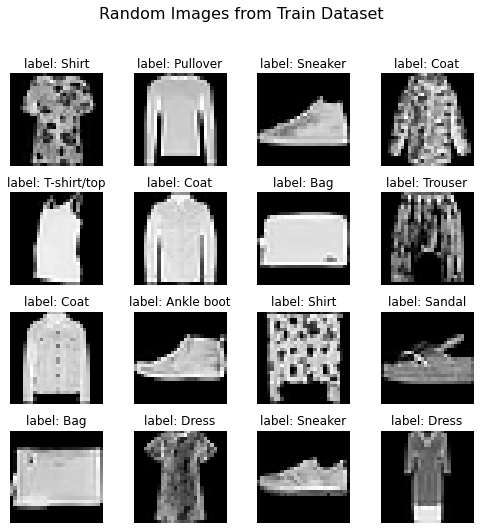

In [65]:
# plot random images from train dataset 
plot_images(4)

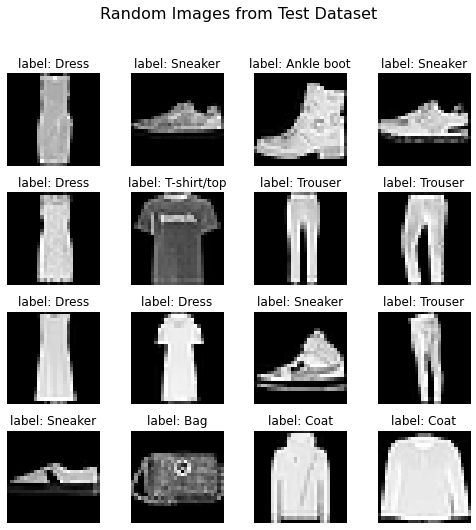

In [66]:
# plot random images from test dataset 
plot_images(4, train=False)

In [67]:
def plot_images_by_class(n, category=0):
  """
    Plot n by n random train images from a given category 
     
      n: number of columns for plots (n by n subplots)
      Assume: train data = (x_train, y_train)            
  """

  len = 6000  # sample size in each category = 6000
  indexes = np.where(y_train==category)
  indexes = np.asarray(indexes).reshape(len) 
  chosen = np.random.randint(0, len, size=n*n)

  plt.suptitle("Random Images in "+ class_names[category], fontsize=16, y=1.08)
  plt.figure(figsize=(7,7))
  for i in range(n*n):
      plt.subplot(n, n, i + 1)
      image = x_train[indexes[chosen[i]]]
      label = y_train[indexes[chosen[i]]]
      plt.imshow(image, cmap='gray')
      plt.title('label: {}'.format(class_names[label]))
      plt.tight_layout()
      plt.axis('off')

<Figure size 432x288 with 0 Axes>

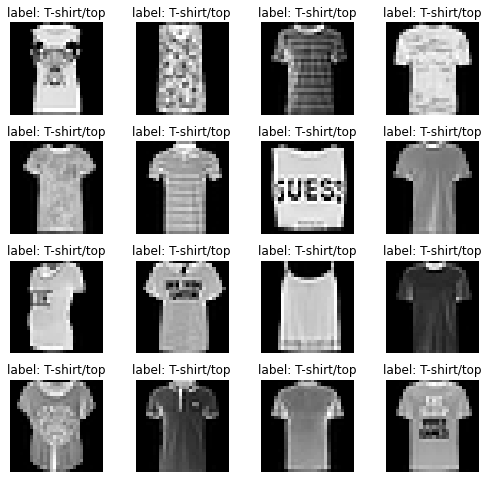

In [68]:
plot_images_by_class(4)

### 손실함수로서의 Cross-entropy

딥러닝에서 분류 모델에 대한 손실 함수로 cross-entropy 혹은 binary entropy 나 log loss 라는 것을 사용하게 된다. 손실함수로서의 cross-entropy 는 아래 식으로 계산할 수 있다. 

$$-\frac{1}{n} \sum_{i=1}^{n}\sum_{c=1}^{C} y_{ic}log(\hat y_{ic})$$
 
여기서, 

$n = $ 데이터 갯수

$C = $ 범주 갯수

$y = $ 실제 값(one-hot 인코딩 형태의 정답) (주로 0 또는 1)

$\hat y = $ 딥러닝 모델의 예측값(확률값) (0~1)  

예를 들어 $C = 3$일 때 두 특정 샘플 $y_1 = [0, 0, 1] $,  $\hat y_1 = [0.1, 0.2, 0.7]$, $y_2 = [0, 0, 1] $,  $\hat y_2 = [0.5, 0.3, 0.2]$라 하자. 이 때,  샘플 1의 경우  cross entropy 는 
$$ 0*log(0.1) + 0*log(0.2) + 1*log(0.7) = -log(0.7) = 0.35 $$ 

샘플 2의 경우 예측 모델은 상당히 잘못 예측했다는 것을 알 수 있고,이 경우 cross entropy 는  
$$ -log(0.2) = 1.6$$ 


딥러닝을 통한 예측 모델링에 있어, cross-entropy가  실제 값과 예측값의 차이(error 혹은 loss)로서의 의미를 가지게 된다는 것을 직관적으로 이해할 수 있다.  

더 자세한 사항을 공부하려면 github에 올려논 [A Gentle Introduction to Cross-Entropy for Machine Learning](https://github.com/sangsin/Introduction-to-Deep-Learning-with-Tensorflow-2.0-and-Keras/blob/main/Lecture%2005~07%20-%20Classification/A%20Gentle%20Introduction%20to%20Cross-Entropy%20for%20Machine%20Learning.ipynb)
을 참고할 것

### Softmax Activation Function

Softmax(소프트맥스)는 입력받은 값을 출력으로 0~1사이의 값으로 모두 정규화하며 출력 값들의 총합은 항상 1이 되는 특성을 가진 함수이다.

  - Softmax는 세개이상으로 분류하는 다중클래스 분류(Multi-class Classification)에서 사용되는 활성화 함수이다.
  - 분류하고 싶은 클래수가 c개라고 할때 c by 1 벡터를 입력받아, 각 클래스에 속할 확률을 출력한다.
  - 가장 큰 출력 값을 부여받은 클래스가 확률이 가장 높은 것으로 이용된다.

입력벡터를 $z = [z_1, z_2, \cdots, z_c]$일때

  $$\hat y_k = \frac{e^{z_k}}{\sum_{i=1}^{c} e^{z_i}}$$

  



In [69]:
import numpy as np

# calculate the softmax of a vector
def softmax(vector):
    e = np.exp(vector)
    return e / e.sum()
 
# define data
data = [1, 3, 2]
# convert list of numbers to a list of probabilities
result = softmax(data)
# report the probabilities
print(result)
# report the sum of the probabilities
print('Sum = ',sum(result))
print('Class =',np.argmax(result))

[0.09003057 0.66524096 0.24472847]
Sum =  1.0
Class = 1


## Build a multiclass classification model

* Loss function = `CategoricalCrossentropy` (if one-hot) else `SparseCategoricalCrossentropy`
* Output activation = `Softmax`
* Input shape = 28x28 (shape of one image)
* Output shape = 10 (1 per class)



In [70]:
from tensorflow.keras import layers, losses, optimizers
from sklearn.metrics import classification_report


from tensorflow.keras.models import Sequential  # Model type to be used
from tensorflow.keras.layers import Dense, InputLayer, Flatten, Activation
from tensorflow.keras.utils import to_categorical, plot_model

from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and testing sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Name of the classes
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

n_classes = len(class_names)
print(f'Number of classes: {n_classes}')

Number of classes: 10


### Get one hot encoded labels

In [71]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

### Scale the images

* The images are 8bit single channel images (Hence the pixel values are intensities between $0$ and $2^8 - 1 = 255$

In [72]:
x_train, x_test = x_train/255.0, x_test/255.0
x_train.shape, x_test.shape


((60000, 28, 28), (10000, 28, 28))

### The `Flatten` layer

* Before passing the images of dim (28, 28) into a simple Deep Neural Network, we need to flatten the images
* Then we can construct the Neural Network layers as usual
* This makes it loose the spatial correlation property, and model now has no hints whatsoever that some pixels are spatially closer to one another. 

In [73]:
input_dim = x_train.shape[1]*x_train.shape[2]
flatten_model = tf.keras.models.Sequential([
    Flatten(input_dim=input_dim)
])

# In ther ways, use 'reshape'


x_train = x_train.reshape(60000, input_dim) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
x_test = x_test.reshape(10000, input_dim)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.


The flatten layer flattens a (28, 28) into 784 (1-D) vector

## Model 1: Simple Deep Neural Network 

### What is the difference between sparse_categorical_crossentropy and categorical_crossentropy?


  - If your targets are one-hot encoded, use categorical_crossentropy. 
  > 
  > [1,0,0]
  >
  > [0,1,0]
  > 
  > [0,0,1]
  >
  - But if your targets are integers, use sparse_categorical_crossentropy. 
  > 
  > [1, 2, 3]
  > 

  - Use sparse categorical crossentropy when your classes are mutually exclusive (e.g. when each sample belongs exactly to one class) and categorical crossentropy when one sample can have multiple classes or labels are soft probabilities (like [0.5, 0.3, 0.2]).

Link: [Sparse_categorical_crossentropy vs categorical_crossentropy (keras, accuracy)](https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy)


In [74]:
# Set random seed
tf.random.set_seed(42)

# Create model
model = tf.keras.models.Sequential([
    Flatten(input_shape = (input_dim,)),
    Dense(128, activation='relu'),
    Dense(4, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(learning_rate=0.001), metrics='accuracy')

# Fit the model
history = model.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=1) # 128 batch size works faster!


Epoch 1/20
422/422 [==============================] - 2s 3ms/step - loss: 1.0462 - accuracy: 0.6279 - val_loss: 0.6257 - val_accuracy: 0.8020
Epoch 2/20
422/422 [==============================] - 1s 3ms/step - loss: 0.5307 - accuracy: 0.8251 - val_loss: 0.4755 - val_accuracy: 0.8357
Epoch 3/20
422/422 [==============================] - 1s 3ms/step - loss: 0.4522 - accuracy: 0.8473 - val_loss: 0.4345 - val_accuracy: 0.8507
Epoch 4/20
422/422 [==============================] - 1s 3ms/step - loss: 0.4087 - accuracy: 0.8592 - val_loss: 0.4115 - val_accuracy: 0.8533
Epoch 5/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3814 - accuracy: 0.8670 - val_loss: 0.4026 - val_accuracy: 0.8575
Epoch 6/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3599 - accuracy: 0.8730 - val_loss: 0.3913 - val_accuracy: 0.8620
Epoch 7/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3446 - accuracy: 0.8785 - val_loss: 0.3720 - val_accuracy: 0.8650
Epoch 

In [75]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 516       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                50        
Total params: 101,046
Trainable params: 101,046
Non-trainable params: 0
_________________________________________________________________


## Evaluate the above model

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

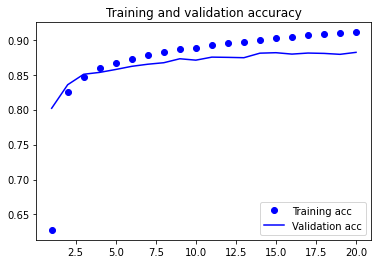

In [77]:
# Plot learning curves for accuracy

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

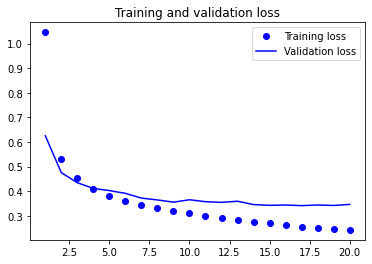

In [78]:
# Plot learning curves for accuracy

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

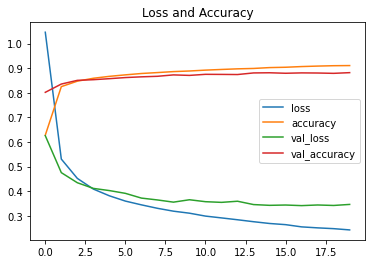

In [79]:
# Alternative Method

import pandas as pd
pd.DataFrame(history.history).plot(title="Loss and Accuracy")

Seems like the model has stopped learning more patterns, and seems underfitted. Maybe if we increase the number of neurons in each layer.

### Test Loss and Test Accuracy 

In [80]:
# accuray and loss using test images
loss, accuracy = model.evaluate(x_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

313/313 [==============================] - 1s 2ms/step - loss: 0.3724 - accuracy: 0.8705
Test loss: 0.3724164366722107
Test accuracy: 0.8705000281333923


### 분류성능평가지표 - 혼동행렬(Confusion Matrix)

## Model 2: Simple Deep Neural Network - 2layer - larger

In [81]:
# The data has already been sorted into training and testing sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape)

# Flatten image data in order to be used as a dense layer input 
x_train = x_train.reshape(60000, input_dim) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
x_test = x_test.reshape(10000, input_dim)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

# Scaling
x_train, x_test = x_train/255.0, x_test/255.0

# One-hot encoding for labels
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 784) (60000, 10) (10000, 784) (10000, 10)


In [82]:
# set seed
tf.random.set_seed(42)

# Create the model
model = tf.keras.models.Sequential([
    layers.Flatten(input_dim = input_dim),
    layers.Dense(128, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

# Compile the model
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(1e-3), metrics='accuracy')

In [83]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 10)                330       
Total params: 104,938
Trainable params: 104,938
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Fit the model
history = model.fit(x_train, y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=1)

Epoch 1/20
422/422 [==============================] - 2s 3ms/step - loss: 0.5720 - accuracy: 0.8017 - val_loss: 0.4301 - val_accuracy: 0.8487
Epoch 2/20
422/422 [==============================] - 1s 3ms/step - loss: 0.4091 - accuracy: 0.8548 - val_loss: 0.3775 - val_accuracy: 0.8635
Epoch 3/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3675 - accuracy: 0.8677 - val_loss: 0.3813 - val_accuracy: 0.8595
Epoch 4/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3394 - accuracy: 0.8777 - val_loss: 0.3627 - val_accuracy: 0.8677
Epoch 5/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3239 - accuracy: 0.8821 - val_loss: 0.3373 - val_accuracy: 0.8733
Epoch 6/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3056 - accuracy: 0.8880 - val_loss: 0.3534 - val_accuracy: 0.8742
Epoch 7/20
422/422 [==============================] - 1s 3ms/step - loss: 0.2930 - accuracy: 0.8929 - val_loss: 0.3365 - val_accuracy: 0.8770
Epoch 

### Plot learning curve

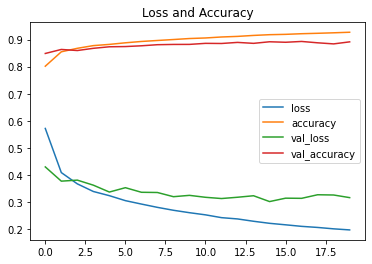

In [85]:
# Alternative Method

import pandas as pd
pd.DataFrame(history.history).plot(title="Loss and Accuracy")

Our model improved a little bit with addition of more neurons and it doesn't seem to overfit!

In [86]:
# Confusion Matrix

# Get predicted class for X_test by converting all of the predictions from probabilities to labels
y_probs = model.predict(x_test)
#print(tf.argmax(pred[0:10]))
print(y_probs[0:10])

y_pred=y_probs.argmax(axis=1)

print('Predicted class probability\n',y_pred[0:10])
print('One-hot encoded labels\n',y_test[0:10])

# To compare y_pred with y_test, y_test should be decoded as a vector.
labels = y_test.argmax(axis=1)
print('Decoded labels\n',labels[0:10])

# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=labels, y_pred=y_pred)
cm = pd.DataFrame(cm)
cm['sum']= cm.sum(axis=1)
cm.loc['Total']= cm.sum()
cm

[[3.36112265e-07 3.01187374e-11 1.14988381e-06 2.17339732e-07
  1.34013955e-09 3.01843206e-03 3.73155490e-06 3.81118059e-03
  1.41669370e-08 9.93164957e-01]
 [7.92301871e-05 4.14721290e-14 9.99553978e-01 1.27404514e-08
  2.54195620e-04 2.36601311e-15 1.12583461e-04 1.08102882e-12
  9.98678473e-10 3.37273113e-12]
 [1.14712817e-09 1.00000000e+00 2.03311690e-11 8.67920491e-09
  6.70766165e-10 2.59053695e-17 1.36809142e-09 1.10524598e-21
  3.34133207e-11 2.50630829e-17]
 [2.33760204e-07 9.99996662e-01 1.43400525e-09 2.86128488e-06
  2.86999988e-08 3.54592169e-13 2.50622890e-07 8.21724116e-18
  1.62714608e-09 8.56357465e-13]
 [2.45758697e-01 1.25563977e-08 1.92010426e-03 4.90771432e-04
  1.78704178e-03 9.28539676e-11 7.50041544e-01 1.27306243e-09
  1.76093670e-06 3.68755408e-08]
 [3.80824667e-06 9.99981284e-01 1.88924588e-07 5.47919626e-06
  1.34943457e-06 5.81997124e-12 7.85268912e-06 6.52437927e-15
  4.85941207e-08 8.69869606e-13]
 [5.85659222e-07 6.52231074e-06 2.77558778e-04 8.61344233e

,0,1,2,3,4,5,6,7,8,9,sum
0,858,3,8,20,5,2,98,0,6,0,1000
1,4,973,0,15,5,0,2,0,1,0,1000
2,20,1,758,13,95,0,113,0,0,0,1000
3,21,9,6,882,44,1,30,0,6,1,1000
4,1,0,79,27,816,0,76,0,1,0,1000
5,0,0,0,0,0,971,0,19,1,9,1000
6,138,1,48,23,51,1,731,0,7,0,1000
7,0,0,0,0,0,11,0,972,0,17,1000
8,5,0,2,3,7,3,7,4,969,0,1000
9,0,0,0,0,0,14,1,48,0,937,1000



      0 : T-shirt/top 
      1 : Trouser
      2 : Pullover
      3 : Dress
      4 : Coat
      5 : Sandal
      6 : Shirt
      7 : Sneaker
      8 : Bag
      9 : Ankle boot


In [87]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

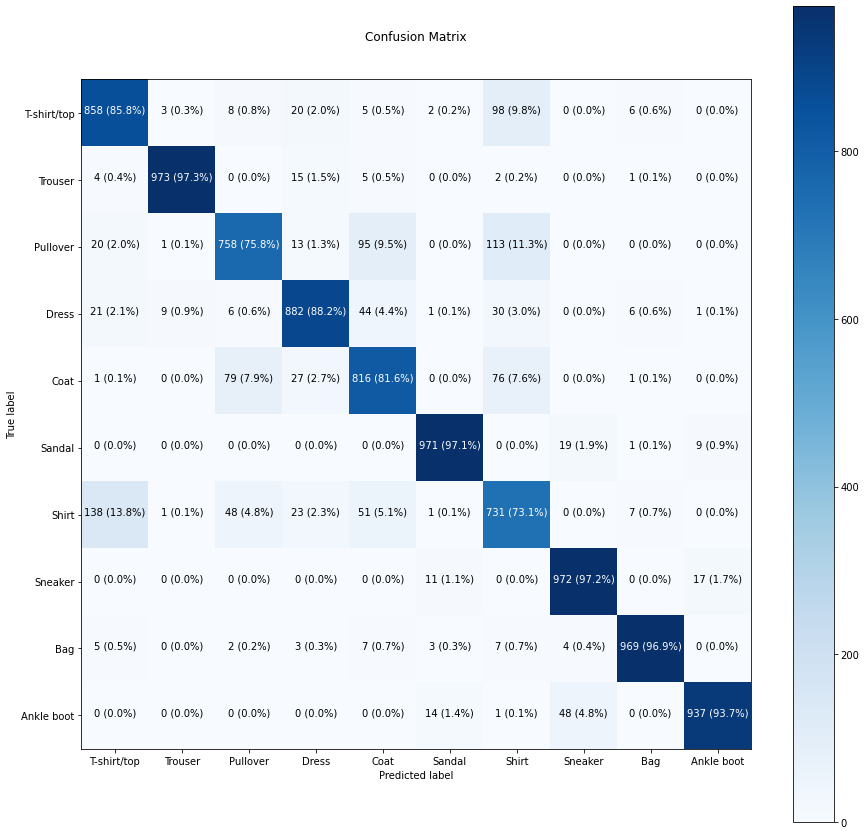

In [88]:
# Make a prettier confusion matrix

#class_names=[str(i) for i in range(0,10)]
make_confusion_matrix(y_true=labels, 
                      y_pred=y_pred,
                      classes=class_names,
                      figsize=(15, 15),
                      text_size=10)

### Precision, Recall, and F1-score

In [89]:
# Let's consider the classification results for digit '1',

TP  = cm.iat[0,0]
FN = cm.iat[0, 10]-TP
FP = cm.iat[10, 0]-TP

precision = TP/(TP +FP)
recall = TP/(TP +FN)
F1 = 2*(precision*recall)/(precision+recall)

print("True Positive = {},  False Negative =  {},  False Positive = {}".format(TP,FN,FP))
print("\nPrecision = {:.4f},  Recall =  {:.4f},  F1 Score = {:.4f}".format(precision,recall,F1))


True Positive = 858,  False Negative =  142,  False Positive = 189

Precision = 0.8195,  Recall =  0.8580,  F1 Score = 0.8383


In [90]:
# Use sklearn classification_report.

from sklearn.metrics import classification_report
print(classification_report(labels, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8195    0.8580    0.8383      1000
           1     0.9858    0.9730    0.9794      1000
           2     0.8413    0.7580    0.7975      1000
           3     0.8973    0.8820    0.8896      1000
           4     0.7977    0.8160    0.8067      1000
           5     0.9681    0.9710    0.9695      1000
           6     0.6909    0.7310    0.7104      1000
           7     0.9319    0.9720    0.9515      1000
           8     0.9778    0.9690    0.9734      1000
           9     0.9720    0.9370    0.9542      1000

    accuracy                         0.8867     10000
   macro avg     0.8882    0.8867    0.8870     10000
weighted avg     0.8882    0.8867    0.8870     10000



## Inspecting FN/FP

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

### Visualize FN

In [91]:
# 앞서데이터 전처리과정에서에서 우리는 28 by 28 이차원 이미지데이터 1차원 벡터로 Reshape 시켜놓았다. 
# 이미지 플로팅을 위해 우리는 다시 이미지를 이차원으로 변화 시킨다.

x_test = x_test.reshape(10000, 28,28) 

In [92]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot FN classified images

def show_FN(x_test,y_test, y_pred, true_class):

  dict = {'True Class': y_test,'Predicted Class':y_pred}
  df = pd.DataFrame(dict)
  df['row_num'] = df.index
  df = df[df['True Class']==true_class]
  df = df[df['True Class'] != df['Predicted Class']]
  n = df.shape[0] # sample size
  # print("Total Rows = ",n)
  # print(df)

  number_of_subplots=25 if n >= 26 else n
  rows = 5
  
  plt.figure(figsize=(10, 10))
  plt.suptitle("True Class: "+ class_names[true_class], fontsize=16, y=1.08)

 
  for i in range(number_of_subplots):
    ax = plt.subplot(rows, rows, i + 1)
    plt.imshow(x_test[df.iat[i,2]], cmap='gray')
    plt.title("Pred: {}".format(class_names[df.iat[i,1]]))
    plt.axis(False)

  # number_of_subplots=25 if n >= 36 else n

  # for i,v in enumerate(xrange(number_of_subplots)):
  #   v = v+1
  #   ax1 = subplot(number_of_subplots,1,v)
  #   plt.imshow(x_test[df.iat[i,2]], cmap='gray')
  #   plt.title("True: {} Pred: {} ".format(df.iat[i,0],df.iat[i,1]))
  #   plt.axis(False)




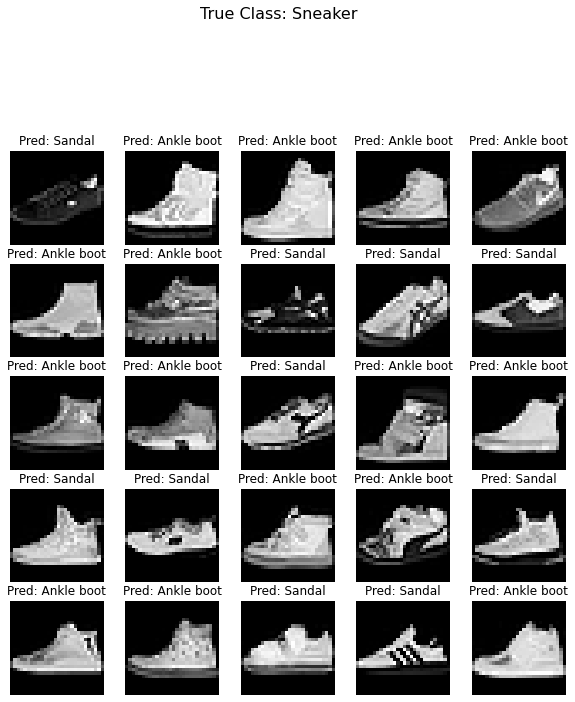

In [93]:
show_FN(x_test,labels, y_pred,7 )

  
      0 : T-shirt/top 
      1 : Trouser
      2 : Pullover
      3 : Dress
      4 : Coat
      5 : Sandal
      6 : Shirt
      7 : Sneaker
      8 : Bag
      9 : Ankle boot

In [94]:
### Visualize FP

In [95]:
# Plot FP classified images

def show_FP(x_test,y_test, y_pred, pred_class):

  dict = {'True Class': y_test,'Predicted Class':y_pred}
  df = pd.DataFrame(dict)
  df['row_num'] = df.index
  df = df[df['Predicted Class']==pred_class]
  df = df[df['True Class'] != df['Predicted Class']]
  n = df.shape[0] # sample size

  number_of_subplots=25 if n >= 26 else n
  rows = 5
  
  plt.figure(figsize=(10, 10))
  plt.suptitle("Predicted Class: "+ class_names[pred_class], fontsize=16, y=1.08)

  for i in range(number_of_subplots):
    ax = plt.subplot(rows, rows, i + 1)
    plt.imshow(x_test[df.iat[i,2]], cmap='gray')
    plt.title("True: {}".format(class_names[df.iat[i,0]]))
    plt.axis(False)



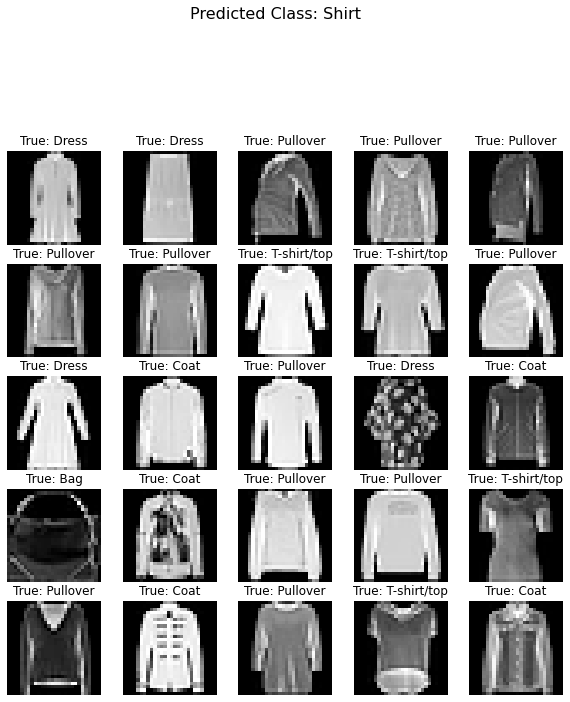

In [96]:
show_FP(x_test,labels, y_pred, 6)

Even though we have achieved a really good performance, seems like we are not decreasing loss as fast as we could! We can finding a better learning rate

## Model 3: Fine-Tuning for better learning rate

### Finding the ideal learning rate

* Using a `LearningRateScheduler` we vary the learning_rate with epoch
* Slowly increasing it from 1e-3 to 1e-2 in logspace

#### Making the `LearningRateScheduler`

In [97]:
from tensorflow.keras import callbacks

num_epochs = 20
lr_epochvals = np.logspace(-4, -2, num_epochs)
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: lr_epochvals[epoch])

#### Fitting the model (smaller sample)

In [98]:
model = tf.keras.models.clone_model(model)
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam())
sample_size = 10000
history_lr = model.fit(np.expand_dims(x_train, -1)[:sample_size], y_train[:sample_size], batch_size=128, epochs=num_epochs, callbacks=[lr_scheduler], verbose=0)

#### Learning rate vs epoch plot

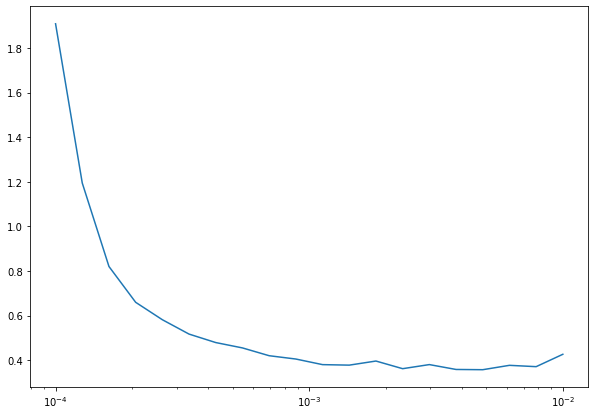

In [99]:
history_lr_df = pd.DataFrame(history_lr.history)

plt.figure(figsize=(10, 7))
plt.semilogx(history_lr_df['lr'], history_lr_df['loss'])

* The loss is decreasing fastest somewhere between $10^{-4}$, and first xtick after.


In [100]:
best_lr = 1e-4 + (1e-4)*1/2
best_lr

0.00015000000000000001

### Refit the model with ideal learning_rate

In [101]:
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(learning_rate=best_lr), metrics=['accuracy'])
history = model.fit(x_train,  y_train, validation_split=0.1, epochs=20, batch_size=128, verbose=1)


Epoch 1/20
422/422 [==============================] - 2s 3ms/step - loss: 0.3614 - accuracy: 0.8713 - val_loss: 0.3651 - val_accuracy: 0.8693
Epoch 2/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3358 - accuracy: 0.8809 - val_loss: 0.3564 - val_accuracy: 0.8718
Epoch 3/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3257 - accuracy: 0.8838 - val_loss: 0.3503 - val_accuracy: 0.8725
Epoch 4/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3173 - accuracy: 0.8861 - val_loss: 0.3436 - val_accuracy: 0.8750
Epoch 5/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3102 - accuracy: 0.8886 - val_loss: 0.3390 - val_accuracy: 0.8772
Epoch 6/20
422/422 [==============================] - 1s 3ms/step - loss: 0.3040 - accuracy: 0.8907 - val_loss: 0.3408 - val_accuracy: 0.8778
Epoch 7/20
422/422 [==============================] - 1s 3ms/step - loss: 0.2978 - accuracy: 0.8922 - val_loss: 0.3334 - val_accuracy: 0.8765
Epoch 

### Plot the learning curve

The overfitting seems amplified because of the scale, but the model has performed better than the previous model (or maybe not! Changes on each run!)

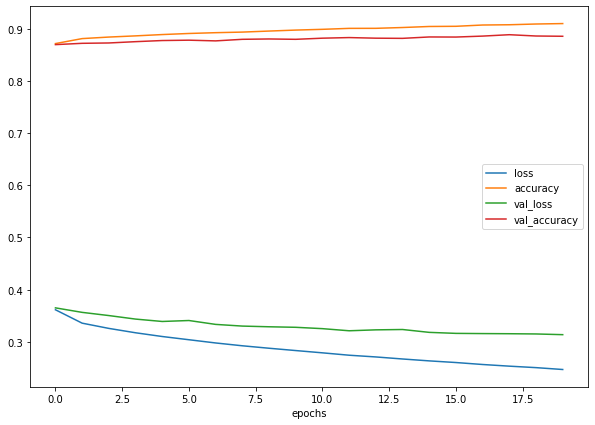

In [102]:
pd.DataFrame(history.history).plot(figsize=(10,7), xlabel="epochs");

### Evaluate the predictions

#### Predictions

* Generally the class with the highest probability is the predicted class (Maybe you can set different thresholds for each class)

In [103]:
y_pred_prob_test = model.predict(np.expand_dims(x_test, -1))
y_pred_test = y_pred_prob_test.argmax(axis=1)
y_pred_test.shape, y_test.shape

((10000,), (10000, 10))

#### Confusion matrix

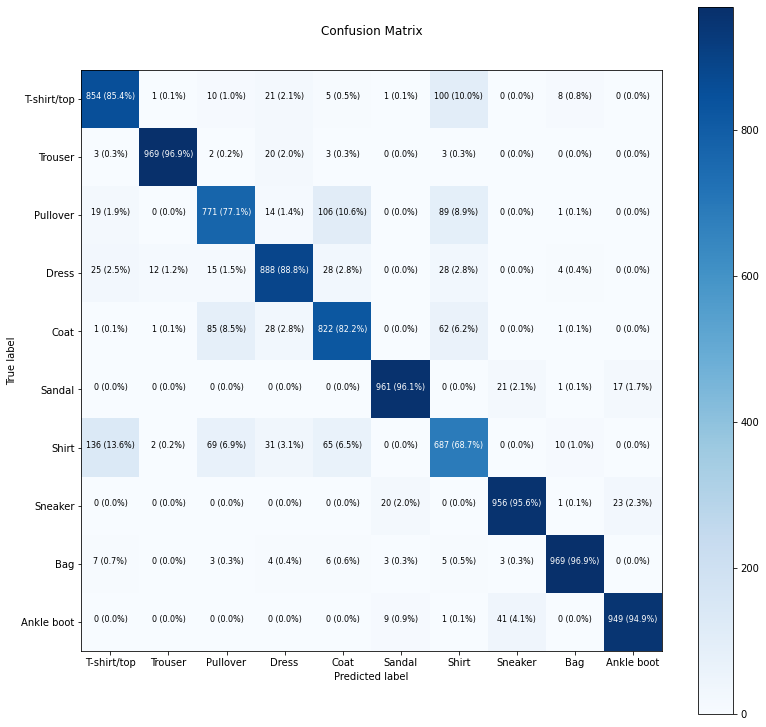

In [104]:
labels = y_test.argmax(axis=1)
ax = make_confusion_matrix(labels, y_pred_test, classes=class_names, figsize=(13, 13), text_size=8)

#### Classification metrics

In [105]:
print(classification_report(labels, y_pred_test, target_names=class_names, output_dict=False))

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.85      0.84      1000
     Trouser       0.98      0.97      0.98      1000
    Pullover       0.81      0.77      0.79      1000
       Dress       0.88      0.89      0.89      1000
        Coat       0.79      0.82      0.81      1000
      Sandal       0.97      0.96      0.96      1000
       Shirt       0.70      0.69      0.70      1000
     Sneaker       0.94      0.96      0.95      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.96      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

